<a href="https://colab.research.google.com/github/abdullahArshadCheema/Artifical_Neural_Network_Model/blob/main/PredictingStockPricesUsingLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Preprocess Data
In the <b>Q1_Dataset</b> folder you will find `TSLA.csv`, `GOOGL.csv` and `DJI.csv` files. Use Pandas lbrary to retrieve the dataset. Use only <b>Open</b> price as your input. (You will train three models for three different stocks, don't mix these data together!)

In [76]:
dataset = pd.read_csv("/content/DJI.csv")

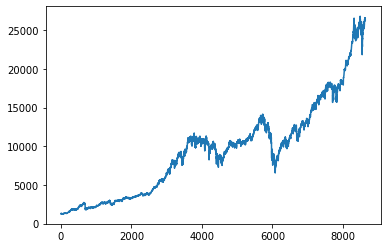

In [77]:
df2 = dataset['Open']
plt.plot(df2)

## Normalize your data
You could use `MinMaxScaler` in `sklearn.preprocessing` to normalize the data between 0 and 1.

In [78]:
scalar = MinMaxScaler(feature_range=(0, 1))
df1 = scalar.fit_transform(np.array(df2).reshape(-1, 1))

In [79]:
df1.shape

(8636, 1)

# Split training, validation and testing data
<p style="font-size:20px">Since you will impelement a many-to-one Recurrent Neural Network model, every input data will have shape [batch_size, num_seq, input_size] and output data will have shape [batch_size, input_size] 

In [80]:
training_size = int(len(df1)*0.80)
test_size = len(df1) - training_size
train_data, test_data = df1[0: training_size, :], df1[training_size:len(df1), :1]

In [81]:
def create_dataset(dataset, time_step=1):
  data_X, data_y = [], []
  for i in range(len(dataset)-time_step-1):
    temp = dataset[i:(i+time_step), 0]
    data_X.append(temp)
    data_y.append(dataset[i+time_step, 0])
  
  return np.array(data_X), np.array(data_y)


In [82]:
time_step=100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [83]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [84]:
X_train.shape, X_test.shape

((6807, 100, 1), (1627, 100, 1))

# TesnorFlow Model

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [86]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(1))

In [87]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [88]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout_9 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_10 (LSTM)              (None, 100, 50)           20200     
                                                                 
 dropout_10 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

# Training

In [90]:
history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
107/107 [==============================] - 22s 207ms/step - loss: 9.0475e-04 - val_loss: 0.0022
Epoch 2/100
107/107 [==============================] - 21s 195ms/step - loss: 6.8428e-04 - val_loss: 0.0025
Epoch 3/100
107/107 [==============================] - 21s 196ms/step - loss: 5.9612e-04 - val_loss: 0.0051
Epoch 4/100
107/107 [==============================] - 21s 195ms/step - loss: 5.7859e-04 - val_loss: 0.0050
Epoch 5/100
107/107 [==============================] - 21s 192ms/step - loss: 5.1163e-04 - val_loss: 0.0011
Epoch 6/100
107/107 [==============================] - 21s 197ms/step - loss: 4.9549e-04 - val_loss: 0.0042
Epoch 7/100
107/107 [==============================] - 21s 200ms/step - loss: 4.6424e-04 - val_loss: 0.0028
Epoch 8/100
107/107 [==============================] - 21s 200ms/step - loss: 4.7072e-04 - val_loss: 0.0019
Epoch 9/100
107/107 [==============================] - 21s 200ms/step - loss: 4.2958e-04 - val_loss: 0.0011
Epoch 10/100
107/107 [======

In [ ]:
print(history.history.keys())

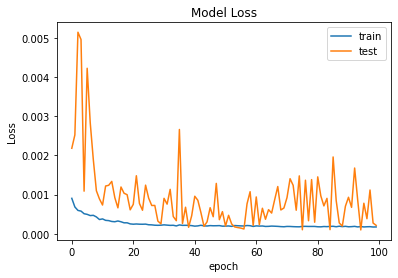

In [93]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
plt.show()

# Testing

In [94]:
model.evaluate(X_test, y_test)

51/51 [==============================] - 2s 35ms/step - loss: 2.1479e-04


0.00021479403949342668

**Plotting 100 days predictions**

In [95]:
# Prediction vectors
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

51/51 [==============================] - 2s 36ms/step


In [96]:
# Transformation to original values
train_predict = scalar.inverse_transform(train_predict)
test_predict = scalar.inverse_transform(test_predict)

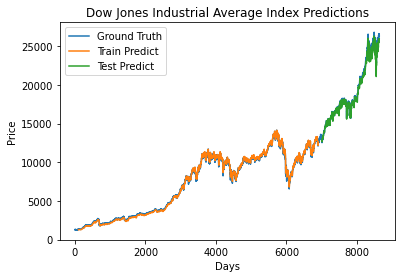

In [98]:
look_back=100
# Shift Train predictions for plotting
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1: len(df1)-1, :] = test_predict

# Plot baseline and predictions
plt.title("Dow Jones Industrial Average Index Predictions")
plt.plot(scalar.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend(["Ground Truth", "Train Predict", "Test Predict"])
plt.show()